In [8]:
pip install vaderSentiment

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import datetime
import warnings

warnings.filterwarnings('ignore')

In [9]:
stocks = ['AMZN', 'JPM', 'META', 'TSLA','F']
data = {}

for stock in stocks:
    data[stock] = yf.download(stock, start='2010-01-01', end=datetime.date.today())[["Close"]]

vix_data = yf.download('^VIX', start='2010-01-01', end=datetime.date.today())[["Close"]]
vix_data.rename(columns={"Close": "VIX"}, inplace=True)

for stock in stocks:
    data[stock] = data[stock].join(vix_data, how="inner")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
analyzer = SentimentIntensityAnalyzer()

def generate_synthetic_sentiment(length):
    np.random.seed(42)
    return np.random.normal(loc=0, scale=0.5, size=length)

for stock in stocks:
    data[stock]['Sentiment'] = generate_synthetic_sentiment(len(data[stock]))


In [11]:

arima_predictions = {}
for stock in stocks:
    print(f"Training ARIMA model for {stock}...")


    df = data[stock].dropna()

    exog_vars = df[['VIX', 'Sentiment']]
    arima_model = ARIMA(df['Close'], exog=exog_vars, order=(5,1,0))
    arima_fit = arima_model.fit()

    exog_future = exog_vars[-30:]
    arima_pred = arima_fit.predict(start=len(df), end=len(df)+29, exog=exog_future, typ='levels')

    arima_predictions[stock] = arima_pred


Training ARIMA model for AMZN...
Training ARIMA model for JPM...
Training ARIMA model for META...
Training ARIMA model for TSLA...
Training ARIMA model for F...


Evaluating ARIMA model for AMZN...
AMZN - MAE: 2.16, MSE: 7.45, RMSE: 2.73


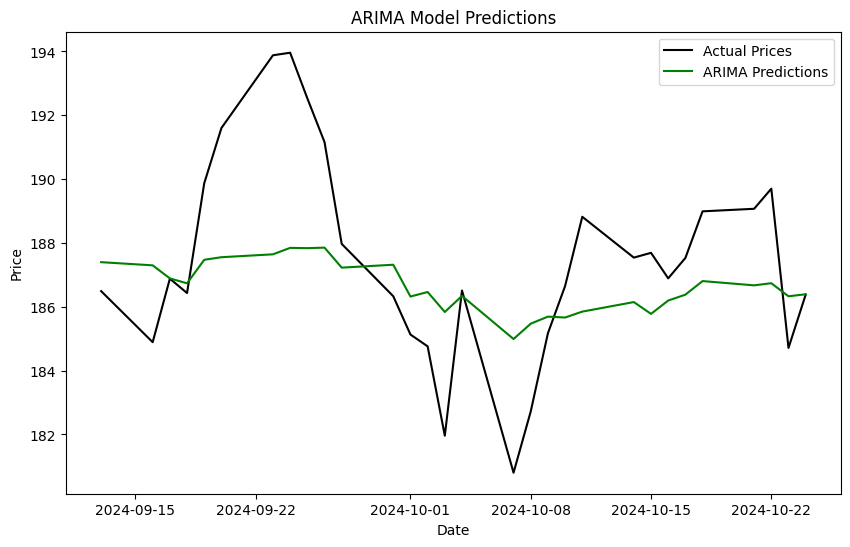

Evaluating ARIMA model for JPM...
JPM - MAE: 10.99, MSE: 171.81, RMSE: 13.11


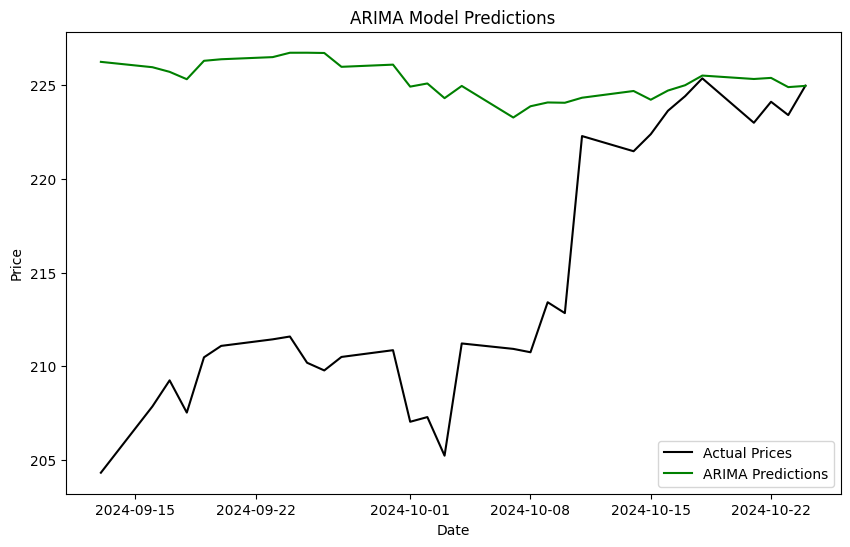

Evaluating ARIMA model for META...
META - MAE: 15.35, MSE: 370.09, RMSE: 19.24


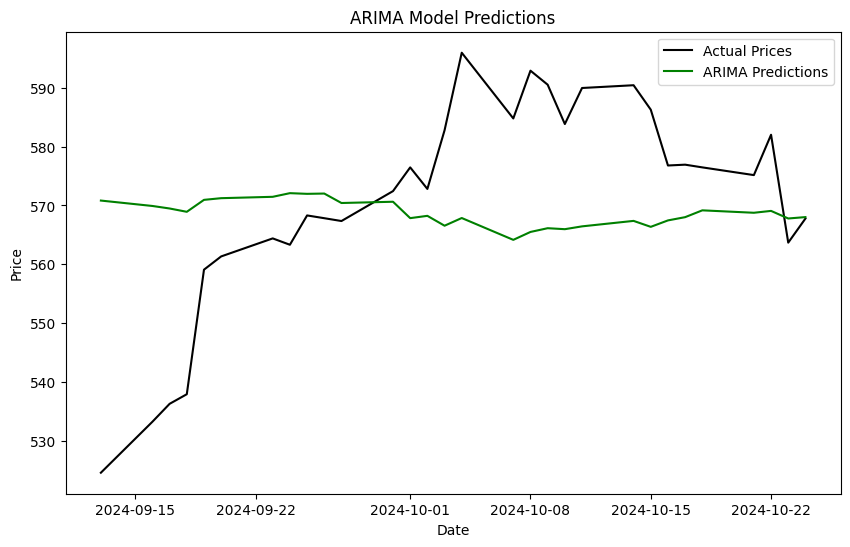

Evaluating ARIMA model for TSLA...
TSLA - MAE: 24.11, MSE: 803.86, RMSE: 28.35


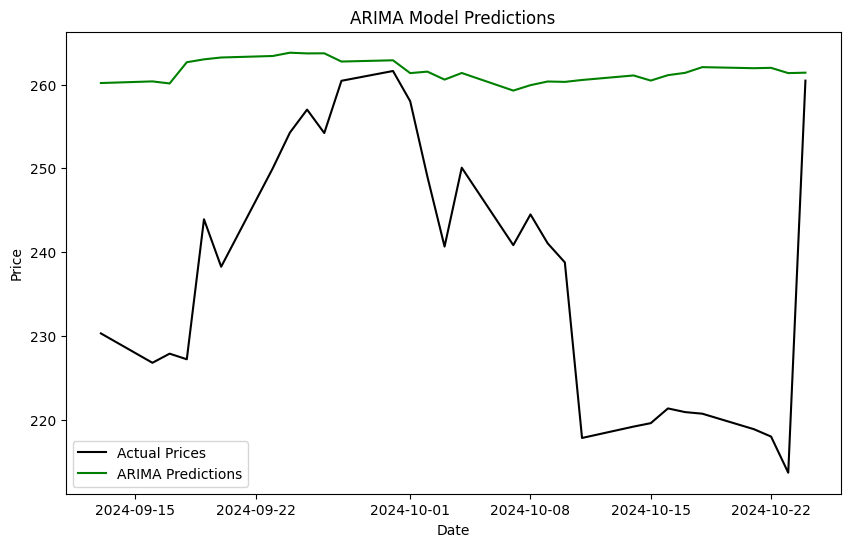

Evaluating ARIMA model for F...
F - MAE: 0.50, MSE: 0.30, RMSE: 0.55


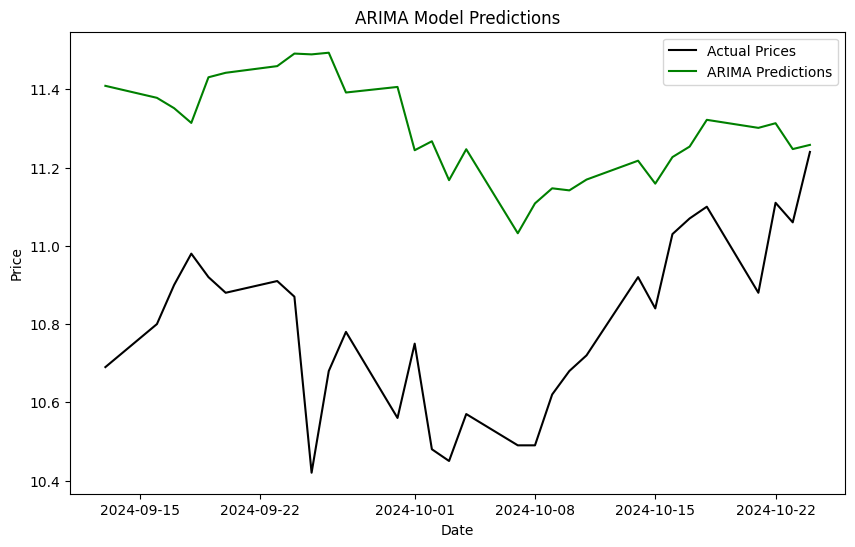

In [13]:

evaluation_metrics = {}

for stock in stocks:
    print(f"Evaluating ARIMA model for {stock}...")


    df = data[stock].dropna()
    true_values = df['Close'][-30:]
    mae = mean_absolute_error(true_values, arima_predictions[stock])
    mse = mean_squared_error(true_values, arima_predictions[stock])
    rmse = np.sqrt(mse)
    evaluation_metrics[stock] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

    # Print metrics
    print(f"{stock} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")


    plt.figure(figsize=(10, 6))
    plt.plot(true_values.index, true_values, label="Actual Prices", color="black")
    plt.plot(true_values.index, arima_predictions[stock], label="ARIMA Predictions", color="green")
    plt.title("ARIMA Model Predictions")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


In [ ]:
for stock, metrics in evaluation_metrics.items():
    print(f"\n{stock} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")



AMZN Performance:
MAE: 5.24
MSE: 42.73
RMSE: 6.54

JPM Performance:
MAE: 4.68
MSE: 30.48
RMSE: 5.52

META Performance:
MAE: 52.00
MSE: 3572.21
RMSE: 59.77

TSLA Performance:
MAE: 17.19
MSE: 448.80
RMSE: 21.18

F Performance:
MAE: 0.18
MSE: 0.05
RMSE: 0.22
